In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [41]:
import yfinance as yf

ticker = "ANTM.JK"

# Ticker = yf.Ticker(ticker)
# price_history = Ticker.history(period="4y")
# price_history.to_csv(f'{ticker}_price_history.csv')

In [42]:
import pandas as pd
price_history = pd.read_csv(f'{ticker}_price_history.csv')

In [43]:
def split_data(data, test_size=0.2):
  data_size = len(data)
  train_size = int(data_size * (1 - test_size))

  data_train = data[:train_size]
  data_test = data[train_size:]

  return data_train, data_test

In [44]:
import numpy as np

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [45]:
price_data_train, price_data_test = split_data(price_history, test_size=0.2)

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_price_train = scaler.fit_transform(price_data_train['Close'].values.reshape(-1, 1))
scaled_price_test = scaler.fit_transform(price_data_test['Close'].values.reshape(-1, 1))

In [47]:
SEQUENCE_LENGTH = 30

X_train, y_train = create_sequences(scaled_price_train, seq_length=SEQUENCE_LENGTH)
X_test, y_test = create_sequences(scaled_price_test, seq_length=SEQUENCE_LENGTH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras import optimizers

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16))
model.add(Dense(1))

opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')

# model.compile(optimizer='adam', loss='mse') # default lr = 10e-3

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 30, 128)           33792     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 76065 (297.13 KB)
Trainable params: 76065 (297.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(filepath='model.weights.h5', monitor='loss', save_weights_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 9s 108ms/step - loss: 0.0645 - val_loss: 0.0166
Epoch 2/30
24/24 [==============================] - 1s 42ms/step - loss: 0.0069 - val_loss: 0.0137
Epoch 3/30
24/24 [==============================] - 1s 40ms/step - loss: 0.0045 - val_loss: 0.0122
Epoch 4/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0030 - val_loss: 0.0079
Epoch 5/30
24/24 [==============================] - 1s 48ms/step - loss: 0.0018 - val_loss: 0.0072
Epoch 6/30
24/24 [==============================] - 1s 45ms/step - loss: 0.0016 - val_loss: 0.0079
Epoch 7/30
24/24 [==============================] - 1s 44ms/step - loss: 0.0016 - val_loss: 0.0093
Epoch 8/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0014 - val_loss: 0.0070
Epoch 9/30
24/24 [==============================] - 1s 40ms/step - loss: 0.0013 - val_loss: 0.0076
Epoch 10/30
24/24 [==============================] - 1s 44ms/step - loss: 0.0012 - val_loss: 0.0071
Epoch 11

In [50]:
# LSTM prediction

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE LSTM  : {mse:.7f}")
print(f"RMSE LSTM : {rmse:.7f}")
print(f"MAE LSTM  : {mae:.7f}")


6/6 [==============================] - 2s 16ms/step
MSE LSTM  : 0.0050282
RMSE LSTM : 0.0709100
MAE LSTM  : 0.0553246


In [51]:
y_pred_rescaled = scaler.inverse_transform(y_pred) 

In [52]:
train_size = len(price_data_train)
train_price_plot = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot['Prediction'] = y_pred_rescaled.flatten()

/tmp/ipykernel_10777/1873714381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot['Prediction'] = y_pred_rescaled.flatten()


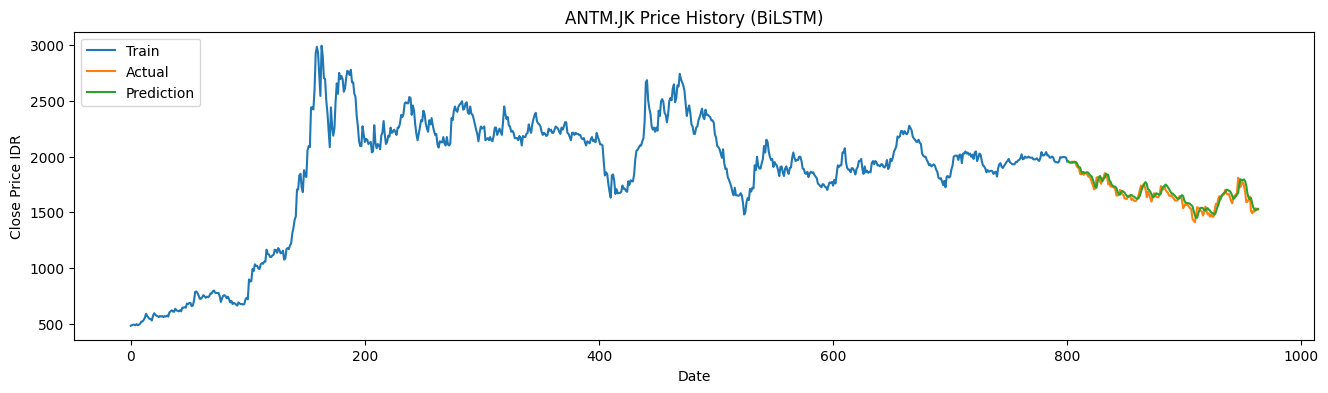

In [53]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Price History (BiLSTM)')
plt.plot(train_price_plot['Close'])
plt.plot(test_price_plot[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()

# RandomForestRegressor

In [54]:
from sklearn.ensemble import RandomForestRegressor

X_train_2d = X_train.squeeze()
y_train_1d = y_train.squeeze()

rf = RandomForestRegressor(n_estimators=100,random_state=42, max_depth=10)
rf.fit(X_train_2d, y_train_1d)

RandomForestRegressor(max_depth=10, random_state=42)

In [55]:
print([estimator.tree_.max_depth for estimator in rf.estimators_])

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [56]:
X_test_2d = X_test.squeeze()

y_pred_rf = rf.predict(X_test_2d)
y_test_1d = y_test.squeeze()

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)
# mape error using sklearn



print(f"MSE RF  : {mse:.7f}")
print(f"RMSE RF : {rmse:.7f}")
print(f"MAE RF  : {mae:.7f}")


MSE RF  : 0.0171719
RMSE RF : 0.1310415
MAE RF  : 0.1004758


In [57]:
y_pred_rescaled_rf = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))

In [58]:
train_size = len(price_data_train)
train_price_plot_rf = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot_rf = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()

/tmp/ipykernel_10777/11579854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()


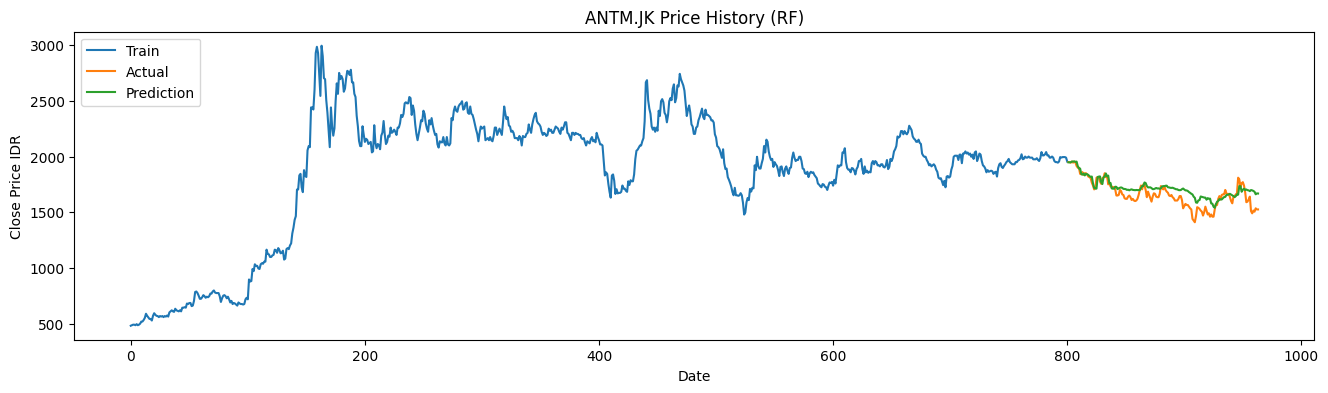

In [59]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Price History (RF)')
plt.plot(train_price_plot_rf['Close'])
plt.plot(test_price_plot_rf[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()